In [171]:
import pandas as pd
import numpy as np

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt


In [173]:
fact_orders = pd.read_csv("fact_orders.csv")
fact_order_items = pd.read_csv("fact_order_items.csv")
fact_ratings = pd.read_csv("fact_ratings.csv")
fact_delivery = pd.read_csv("fact_delivery_performance.csv")

dim_customer = pd.read_csv("dim_customer.csv")
dim_restaurant = pd.read_csv("dim_restaurant.csv")
dim_delivery_partner = pd.read_csv("dim_delivery_partner_.csv")
dim_menu_item = pd.read_csv("dim_menu_item.csv")


In [174]:
fact_orders.head(10)

,order_id,customer_id,restaurant_id,delivery_partner_id,order_timestamp,subtotal_amount,discount_amount,delivery_fee,total_amount,is_cod,is_cancelled
0,ORD202501023439,CUST181110,REST08622,DP05541,2025-01-01 12:00:00,471.62,35.44,30.56,466.74,N,N
1,ORD202501012051,CUST025572,REST02383,DP08091,2025-01-01 12:00:00,255.68,0.00,27.45,283.13,Y,N
2,ORD202501019281,CUST179306,REST14069,DP02021,2025-01-01 12:00:00,428.38,0.00,26.23,454.61,N,N
3,ORD202501000124,CUST191820,REST19745,DP13859,2025-01-01 12:00:00,260.81,0.00,32.75,293.56,N,N
4,ORD202501006518,CUST033760,REST12962,DP09615,2025-01-01 12:00:00,280.33,0.00,25.57,305.90,N,N
5,ORD202501018255,CUST011850,REST01307,DP14063,2025-01-01 12:01:00,310.95,0.00,35.05,345.99,Y,N
6,ORD202501004299,CUST107475,REST12542,DP07728,2025-01-01 12:02:00,206.41,0.00,30.62,237.03,Y,N
7,ORD202501018036,CUST093042,REST13907,DP01276,2025-01-01 12:03:00,300.30,48.31,31.41,283.40,N,N
8,ORD202501009329,CUST104825,REST10267,DP03078,2025-01-01 12:04:00,371.60,0.00,34.35,405.95,N,N
9,ORD202501007498,CUST135654,REST05434,DP11625,2025-01-01 12:06:00,306.23,33.38,20.70,293.55,N,N


In [175]:
fact_orders.shape


(149166, 11)

In [176]:
fact_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149166 entries, 0 to 149165
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             149166 non-null  object 
 1   customer_id          149166 non-null  object 
 2   restaurant_id        149166 non-null  object 
 3   delivery_partner_id  143531 non-null  object 
 4   order_timestamp      149166 non-null  object 
 5   subtotal_amount      149166 non-null  float64
 6   discount_amount      149166 non-null  float64
 7   delivery_fee         149166 non-null  float64
 8   total_amount         149166 non-null  float64
 9   is_cod               149166 non-null  object 
 10  is_cancelled         149166 non-null  object 
dtypes: float64(4), object(7)
memory usage: 12.5+ MB


In [177]:
fact_orders['order_timestamp'] = pd.to_datetime(
    fact_orders['order_timestamp'],
    errors='coerce'
)

In [178]:
fact_orders['order_timestamp'].dtype

dtype('<M8[ns]')

In [179]:
def crisis_phase(date):
  if date.year == 2025 and 1 <= date.month <= 5:
    return "Pre_crisis"
  elif date.year == 2025 and 6<= date.month <= 9:
    return "Crisis"
  else:
    return "Recovery"

fact_orders['crisis_phase'] = fact_orders['order_timestamp'].apply(crisis_phase)

In [180]:
fact_orders['crisis_phase'].head(5)

,crisis_phase
0,Pre_crisis
1,Pre_crisis
2,Pre_crisis
3,Pre_crisis
4,Pre_crisis


In [181]:
fact_orders['order_id'].unique()

array(['ORD202501023439', 'ORD202501012051', 'ORD202501019281', ...,
       'ORD202509007687', 'ORD202509002029', 'ORD202509007649'],
      dtype=object)

In [182]:
fact_orders['is_cancelled'].value_counts()

,count
is_cancelled,
N,138054
Y,11112


In [183]:
fact_orders.duplicated(subset='order_id').sum()


np.int64(0)

In [184]:
total_orders = fact_orders['order_id'].nunique()
total_orders

149166

In [185]:
successful_orders = fact_orders[fact_orders['is_cancelled'] == 'N']['order_id'].nunique()
successful_orders

138054

In [186]:
cancelled_orders = fact_orders[fact_orders['is_cancelled'] == 'Y']['order_id'].nunique()
cancelled_orders

11112

In [187]:
total_orders == successful_orders + cancelled_orders

True

In [188]:
fact_orders['crisis_phase'].value_counts()


,count
crisis_phase,
Pre_crisis,113806
Crisis,35360


In [189]:
revenue_by_phase = (
    fact_orders.groupby('crisis_phase')['total_amount']
    .sum()
    .reset_index(name='total_revenue')
)
revenue_by_phase

,crisis_phase,total_revenue
0,Crisis,10940151.31
1,Pre_crisis,37620964.25


In [190]:
revenue_by_phase

,crisis_phase,total_revenue
0,Crisis,10940151.31
1,Pre_crisis,37620964.25


In [191]:
revenue_by_phase['crisis_phase'].tolist()

['Crisis', 'Pre_crisis']

1. Monthly Orders: Compare total orders across pre-crisis (Jan–May 2025) vs crisis (Jun–Sep 2025). How severe is the decline?

In [192]:
fact_orders['order_timestamp'] = pd.to_datetime(fact_orders['order_timestamp'])

In [193]:
fact_orders['month'] = fact_orders['order_timestamp'].dt.to_period('M')

In [194]:
monthly_orders = (
    fact_orders
    .groupby(['month', 'crisis_phase'])['order_id']
    .nunique()
    .reset_index(name='total_orders')
)

monthly_orders

,month,crisis_phase,total_orders
0,2025-01,Pre_crisis,23539
1,2025-02,Pre_crisis,22667
2,2025-03,Pre_crisis,23543
3,2025-04,Pre_crisis,21466
4,2025-05,Pre_crisis,22591
5,2025-06,Crisis,9293
6,2025-07,Crisis,8818
7,2025-08,Crisis,8555
8,2025-09,Crisis,8694


In [195]:
phase_summary = (
    monthly_orders
    .groupby('crisis_phase')['total_orders']
    .sum()
    .reset_index()
)

phase_summary

,crisis_phase,total_orders
0,Crisis,35360
1,Pre_crisis,113806


In [196]:
phase_summary['crisis_phase'] = phase_summary['crisis_phase'].str.lower().str.strip()

orders_dict = phase_summary.set_index('crisis_phase')['total_orders'].to_dict()

decline_pct = (
    (orders_dict.get('crisis', 0) - orders_dict.get('pre-crisis', 0))
    / orders_dict.get('pre-crisis', 1)
) * 100

round(decline_pct, 2)

3536000.0

In [197]:
monthly_orders['month'] = monthly_orders['month'].astype(str)

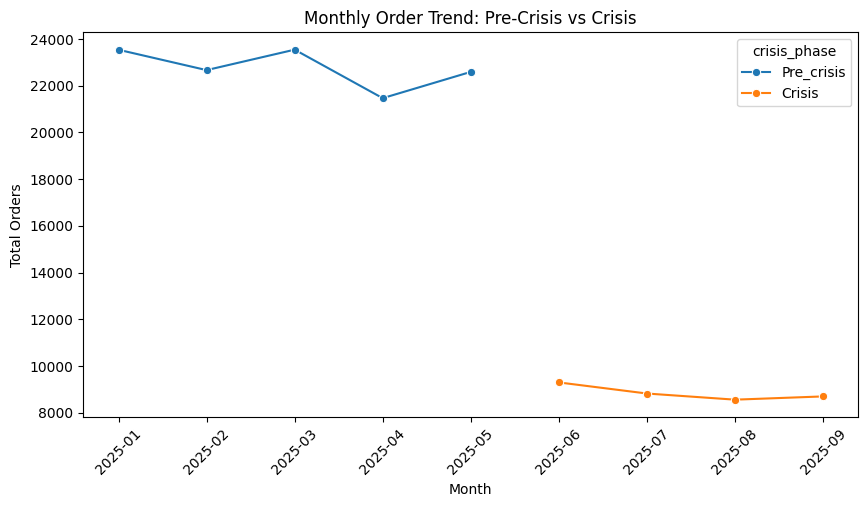

In [198]:
plt.figure(figsize=(10,5))
sns.lineplot(
    data=monthly_orders,
    x='month',
    y='total_orders',
    hue='crisis_phase',
    marker='o'
)

plt.title("Monthly Order Trend: Pre-Crisis vs Crisis")
plt.xlabel("Month")
plt.ylabel("Total Orders")
plt.xticks(rotation=45)
plt.show()

2. Which top 5 city groups experienced the highest percentage decline in orders during the crisis period compared to the pre-crisis period?

In [199]:
fact_orders.head(5)

,order_id,customer_id,restaurant_id,delivery_partner_id,order_timestamp,subtotal_amount,discount_amount,delivery_fee,total_amount,is_cod,is_cancelled,crisis_phase,month
0,ORD202501023439,CUST181110,REST08622,DP05541,2025-01-01 12:00:00,471.62,35.44,30.56,466.74,N,N,Pre_crisis,2025-01
1,ORD202501012051,CUST025572,REST02383,DP08091,2025-01-01 12:00:00,255.68,0.00,27.45,283.13,Y,N,Pre_crisis,2025-01
2,ORD202501019281,CUST179306,REST14069,DP02021,2025-01-01 12:00:00,428.38,0.00,26.23,454.61,N,N,Pre_crisis,2025-01
3,ORD202501000124,CUST191820,REST19745,DP13859,2025-01-01 12:00:00,260.81,0.00,32.75,293.56,N,N,Pre_crisis,2025-01
4,ORD202501006518,CUST033760,REST12962,DP09615,2025-01-01 12:00:00,280.33,0.00,25.57,305.90,N,N,Pre_crisis,2025-01


In [200]:
dim_customer.head(5)

,customer_id,signup_date,city,acquisition_channel
0,CUST000007,21-03-2025,Pune,Organic
1,CUST000008,07-02-2025,Kolkata,Referral
2,CUST000009,25-02-2025,Delhi,Paid
3,CUST000010,28-01-2025,Hyderabad,Paid
4,CUST000011,18-01-2025,Kolkata,Organic


In [201]:
order_city = fact_orders.merge(
    dim_customer[['customer_id', 'city']],
    on = 'customer_id',
    how = 'left'
)

In [202]:
city_phase_orders = (
    order_city
    .groupby(['city', 'crisis_phase'])['order_id']
    .nunique()
    .reset_index(name='total_orders')

)
city_phase_orders

,city,crisis_phase,total_orders
0,Ahmedabad,Crisis,2303
1,Ahmedabad,Pre_crisis,7648
2,Bengaluru,Crisis,9311
3,Bengaluru,Pre_crisis,31277
4,Chennai,Crisis,3521
5,Chennai,Pre_crisis,11046
6,Delhi,Crisis,4704
7,Delhi,Pre_crisis,15580
8,Hyderabad,Crisis,3322
9,Hyderabad,Pre_crisis,10855


In [203]:
city_pivot = city_phase_orders.pivot(
    index = 'city',
    columns = 'crisis_phase',
    values = 'total_orders'

).fillna(0)
city_pivot

crisis_phase,Crisis,Pre_crisis
city,,
Ahmedabad,2303,7648
Bengaluru,9311,31277
Chennai,3521,11046
Delhi,4704,15580
Hyderabad,3322,10855
Kolkata,2296,7601
Mumbai,5322,17848
Pune,2662,8817


In [204]:
city_pivot.columns


Index(['Crisis', 'Pre_crisis'], dtype='object', name='crisis_phase')

In [205]:
city_pivot.columns = (
    city_pivot.columns
    .str.strip()
    .str.lower()
    .str.replace('_', '-')
)

In [206]:
city_pivot['decline_%'] = (
    (city_pivot['crisis'] - city_pivot['pre-crisis']) /
    city_pivot['pre-crisis']
) * 100

city_pivot

crisis_phase,crisis,pre-crisis,decline_%
city,,,
Ahmedabad,2303,7648,-69.887552
Bengaluru,9311,31277,-70.230521
Chennai,3521,11046,-68.124208
Delhi,4704,15580,-69.807445
Hyderabad,3322,10855,-69.396591
Kolkata,2296,7601,-69.793448
Mumbai,5322,17848,-70.181533
Pune,2662,8817,-69.808325


In [207]:
top_5_city_decline = (
    city_pivot
    .sort_values('decline_%')
    .head(5)
)

top_5_city_decline

crisis_phase,crisis,pre-crisis,decline_%
city,,,
Bengaluru,9311,31277,-70.230521
Mumbai,5322,17848,-70.181533
Ahmedabad,2303,7648,-69.887552
Pune,2662,8817,-69.808325
Delhi,4704,15580,-69.807445


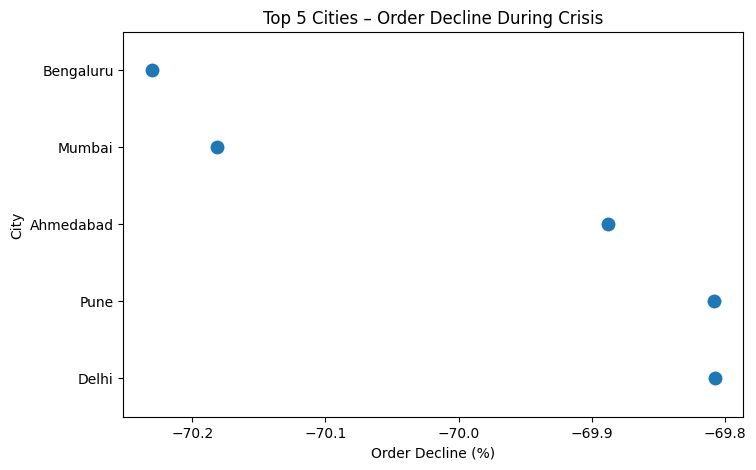

In [208]:
plt.figure(figsize=(8,5))
sns.stripplot(
    data=top_5_city_decline,
    x='decline_%',
    y='city',
    size=10
)

plt.title("Top 5 Cities – Order Decline During Crisis")
plt.xlabel("Order Decline (%)")
plt.ylabel("City")
plt.show()


3. Among restaurants with at least 50 pre-crisis orders, which top 10 high-volume restaurants experienced the largest percentage decline in order counts during the crisis period?

In [209]:
orders_restaurant = fact_orders.merge(
    dim_restaurant[['restaurant_id', 'restaurant_name']],
    on='restaurant_id',
    how='left'
)


In [210]:
rest_phase_orders = (
    orders_restaurant
    .groupby(['restaurant_name', 'crisis_phase'])['order_id']
    .nunique()
    .reset_index(name='total_orders')
)
rest_phase_orders

,restaurant_name,crisis_phase,total_orders
0,Annapurna Biryani Adda,Crisis,3
1,Annapurna Biryani Adda,Pre_crisis,31
2,Annapurna Biryani Bhojanalay,Crisis,15
3,Annapurna Biryani Bhojanalay,Pre_crisis,33
4,Annapurna Biryani Cafe,Crisis,10
...,...,...,...
9478,Urban Wraps Point,Pre_crisis,36
9479,Urban Wraps Stop,Crisis,4
9480,Urban Wraps Stop,Pre_crisis,24
9481,Urban Wraps Zone,Crisis,5


In [211]:
rest_pivot = rest_phase_orders.pivot(
    index='restaurant_name',
    columns='crisis_phase',
    values='total_orders'
).fillna(0)
rest_pivot


crisis_phase,Crisis,Pre_crisis
restaurant_name,,
Annapurna Biryani Adda,3.0,31.0
Annapurna Biryani Bhojanalay,15.0,33.0
Annapurna Biryani Cafe,10.0,18.0
Annapurna Biryani Central,4.0,9.0
Annapurna Biryani Clouds,9.0,24.0
...,...,...
Urban Wraps Nest,11.0,40.0
Urban Wraps Palace,4.0,23.0
Urban Wraps Point,8.0,36.0


In [212]:
rest_pivot = rest_pivot[rest_pivot['Pre_crisis'] >= 50]

In [213]:
rest_pivot['decline_%'] = (
    (rest_pivot['Crisis'] - rest_pivot['Pre_crisis']) /
    rest_pivot['Pre_crisis']
) * 100

rest_pivot

/tmp/ipython-input-3319556874.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_pivot['decline_%'] = (


crisis_phase,Crisis,Pre_crisis,decline_%
restaurant_name,,,
Annapurna Biryani Delight,18.0,54.0,-66.666667
Annapurna Biryani Point,11.0,50.0,-78.000000
Annapurna Delights Clouds,15.0,50.0,-70.000000
Annapurna Delights Zone,13.0,53.0,-75.471698
Annapurna House Darbar,16.0,59.0,-72.881356
...,...,...,...
Urban Delights Delight,17.0,58.0,-70.689655
Urban Kitchen Zone,10.0,67.0,-85.074627
Urban Paratha Corner,18.0,59.0,-69.491525


In [214]:
top_10_restaurant_decline = (
    rest_pivot
    .sort_values('decline_%')
    .head(10)
)

top_10_restaurant_decline


crisis_phase,Crisis,Pre_crisis,decline_%
restaurant_name,,,
Royal Curry Mahal,3.0,50.0,-94.000000
Taste of Cafe Corner,4.0,50.0,-92.000000
Fresh Tandoor Delight,5.0,54.0,-90.740741
Flavours of Curry Cafe,5.0,53.0,-90.566038
Urban Kitchen Zone,10.0,67.0,-85.074627
Punjabi Curry Delight,9.0,58.0,-84.482759
Flavours of Tandoor Central,10.0,64.0,-84.375000
Grand Biryani Hub,8.0,50.0,-84.000000
Hot & Crispy House Heaven,8.0,50.0,-84.000000


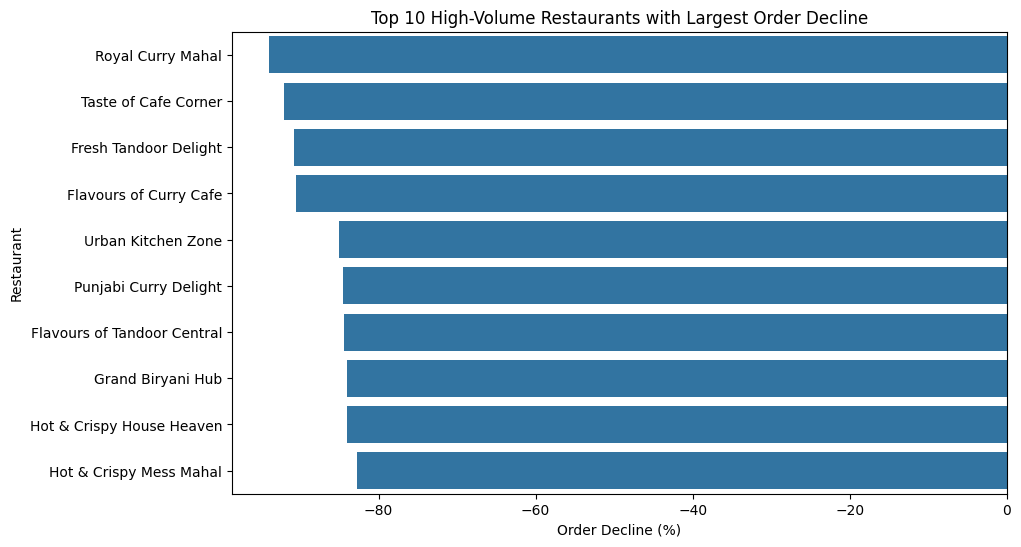

In [215]:
top_10_restaurant_decline = top_10_restaurant_decline.reset_index()

plt.figure(figsize=(10,6))
sns.barplot(
    data=top_10_restaurant_decline,
    x='decline_%',
    y='restaurant_name'
)

plt.title("Top 10 High-Volume Restaurants with Largest Order Decline")
plt.xlabel("Order Decline (%)")
plt.ylabel("Restaurant")
plt.show()

4. Cancellation Analysis: What is the cancellation rate trend pre-crisis vs crisis, and which cities are most affected?

In [216]:
fact_orders['is_cancelled_flag'] = (fact_orders['is_cancelled'] == 'Y')

In [217]:
cancellation_phase = (
    fact_orders
    .groupby('crisis_phase')['is_cancelled_flag']
    .mean()
    .reset_index(name='cancellation_rate_%')
)
cancellation_phase

,crisis_phase,cancellation_rate_%
0,Crisis,0.119287
1,Pre_crisis,0.060577


In [218]:
cancellation_phase['cancellation_rate_%'] = (
    cancellation_phase['cancellation_rate_%'] * 100
).round(2)

cancellation_phase

,crisis_phase,cancellation_rate_%
0,Crisis,11.93
1,Pre_crisis,6.06


In [219]:
orders_city = fact_orders.merge(
    dim_customer[['customer_id', 'city']],
    on='customer_id',
    how='left'
)

In [220]:
city_cancellation = (
    orders_city
    .groupby('city')['is_cancelled_flag']
    .mean()
    .mul(100)
    .reset_index(name='cancellation_rate_%')
    .sort_values('cancellation_rate_%', ascending=False)
)

city_cancellation.head(10)

,city,cancellation_rate_%
3,Delhi,4.338395
2,Chennai,4.304249
4,Hyderabad,4.260422
1,Bengaluru,4.252488
5,Kolkata,4.193190
6,Mumbai,4.130341
7,Pune,4.016029
0,Ahmedabad,3.909155


In [221]:
cancellation_phase['cancellation_rate_%'] = (
    cancellation_phase['cancellation_rate_%']
    .astype(float)
    .round(2)
)

<Axes: xlabel='crisis_phase', ylabel='cancellation_rate_%'>

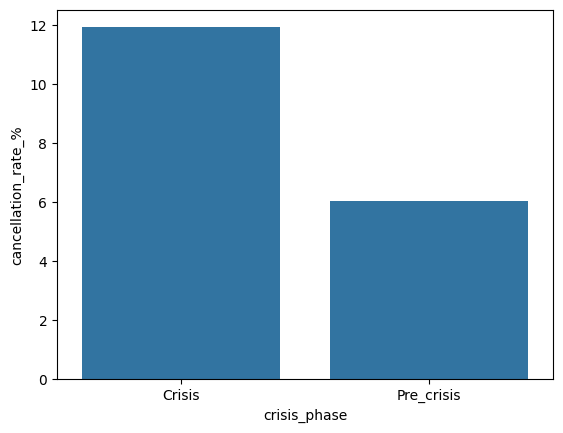

In [222]:
sns.barplot(
    data=cancellation_phase,
    x='crisis_phase',
    y='cancellation_rate_%'
)

5. Delivery SLA: Measure average delivery time across phases. Did SLA compliance worsen significantly in the crisis period?

In [223]:
orders_delivery = fact_orders.merge(
    fact_delivery[['order_id', 'actual_delivery_time_mins', 'expected_delivery_time_mins']],
    on='order_id',
    how='left'
)

In [224]:
avg_delivery_time = (
    orders_delivery
    .groupby('crisis_phase')['actual_delivery_time_mins']
    .mean()
    .reset_index(name='avg_delivery_time_mins')
)

avg_delivery_time['avg_delivery_time_mins'] = avg_delivery_time['avg_delivery_time_mins'].round(1)

avg_delivery_time

,crisis_phase,avg_delivery_time_mins
0,Crisis,60.1
1,Pre_crisis,39.5


In [225]:
orders_delivery['sla_breach'] = (
    orders_delivery['actual_delivery_time_mins'] >
    orders_delivery['expected_delivery_time_mins']
)

In [226]:
sla_breach_rate = (
    orders_delivery
    .groupby('crisis_phase')['sla_breach']
    .mean()
    .mul(100)
    .reset_index(name='sla_breach_%')
)

sla_breach_rate['sla_breach_%'] = sla_breach_rate['sla_breach_%'].round(2)

sla_breach_rate

,crisis_phase,sla_breach_%
0,Crisis,87.8
1,Pre_crisis,56.4


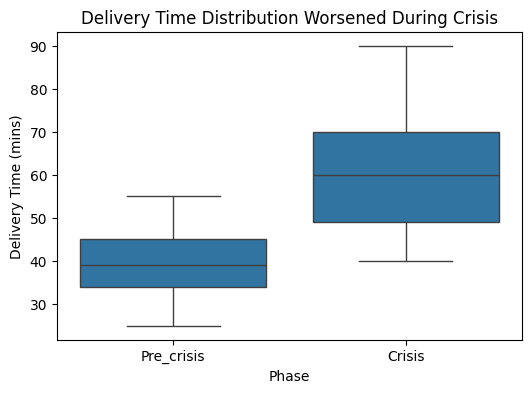

In [227]:
plt.figure(figsize=(6,4))
sns.boxplot(
    data=orders_delivery,
    x='crisis_phase',
    y='actual_delivery_time_mins'
)

plt.title("Delivery Time Distribution Worsened During Crisis")
plt.xlabel("Phase")
plt.ylabel("Delivery Time (mins)")
plt.show()


6. Ratings Fluctuation: Track average customer rating month-by-month. Which months saw the sharpest drop?

In [228]:
orders_ratings = fact_orders.merge(
    fact_ratings[['order_id', 'rating']],
    on = 'order_id',
    how = 'left'
)

In [229]:
orders_ratings['month'] = orders_ratings['order_timestamp'].dt.to_period('M')

In [230]:
monthly_ratings = (
    orders_ratings
    .groupby('month')['rating']
    .mean()
    .reset_index(name='avg_rating')
)

monthly_ratings['avg_rating'] = monthly_ratings['avg_rating'].round(2)

monthly_ratings

,month,avg_rating
0,2025-01,4.58
1,2025-02,4.40
2,2025-03,4.74
3,2025-04,4.29
4,2025-05,4.49
5,2025-06,2.58
6,2025-07,2.69
7,2025-08,2.40
8,2025-09,2.31


In [231]:
monthly_ratings['month'] = monthly_ratings['month'].astype(str)

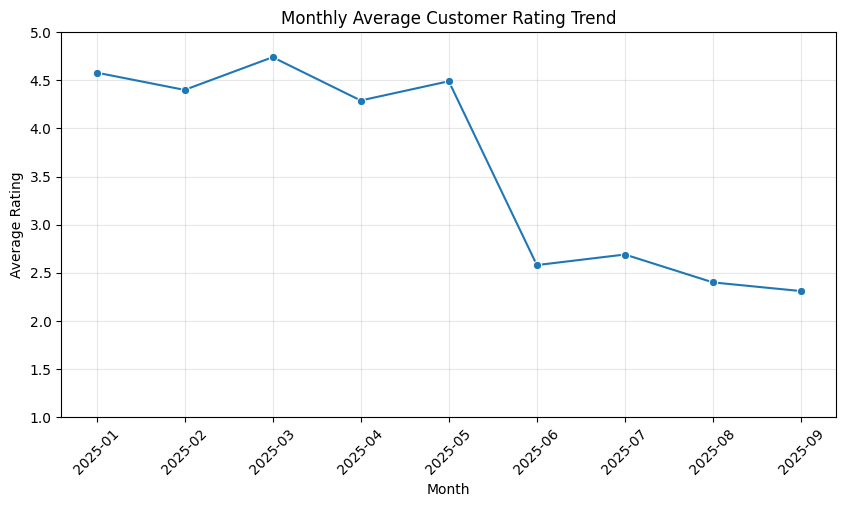

In [232]:
plt.figure(figsize=(10,5))
sns.lineplot(
    data=monthly_ratings,
    x='month',
    y='avg_rating',
    marker='o'
)

plt.title("Monthly Average Customer Rating Trend")
plt.xlabel("Month")
plt.ylabel("Average Rating")
plt.ylim(1, 5)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()


7. Sentiment Analysis: What are the key negative themes in customer reviews during the crisis period?

In [233]:
orders_rating = fact_orders.merge(
    fact_ratings[['order_id', 'rating', 'review_text', 'sentiment_score']],
    on='order_id',
    how='left'
)

In [234]:
avg_rating_phase = (
    orders_rating
    .groupby('crisis_phase')['rating']
    .mean()
    .reset_index(name='avg_rating')
)

avg_rating_phase

,crisis_phase,avg_rating
0,Crisis,2.498199
1,Pre_crisis,4.503741


In [235]:
negative_reviews = orders_rating[
    (orders_rating['crisis_phase'] == 'Crisis') &
    (orders_rating['sentiment_score'] < 0)
]

In [236]:
negative_reviews.shape

(11891, 17)

(np.float64(-0.5), np.float64(799.5), np.float64(399.5), np.float64(-0.5))

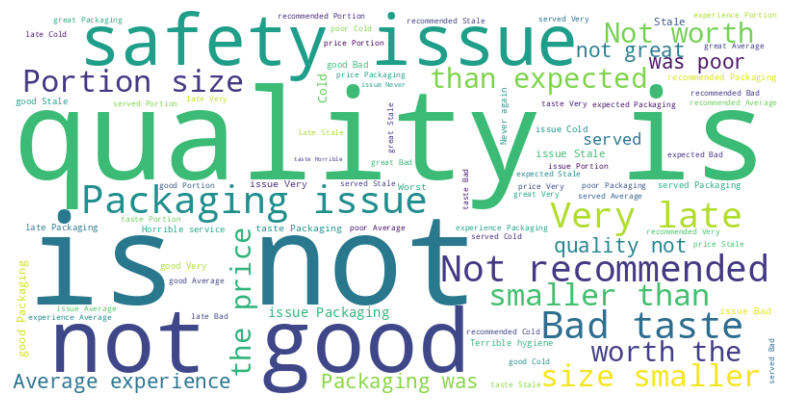

In [237]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(
    negative_reviews['review_text']
    .dropna()
    .astype(str)
)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=set(['food', 'order', 'delivery'])
).generate(text)

plt.figure(figsize=(12,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')


8. Revenue Impact: How much revenue was lost during the crisis compared to the pre-crisis period?

In [238]:
revenue_by_phase = (
    fact_orders
    .groupby('crisis_phase')['total_amount']
    .sum()
    .reset_index(name='total_revenue')
)

In [239]:
revenue_by_phase['crisis_phase'] = (
    revenue_by_phase['crisis_phase']
    .astype(str)
    .str.strip()
    .str.lower()
)

In [240]:
revenue_dict = (
    revenue_by_phase
    .set_index('crisis_phase')['total_revenue']
    .to_dict()
)

pre_crisis_revenue = revenue_dict.get('pre-crisis', 0)
crisis_revenue = revenue_dict.get('crisis', 0)

revenue_loss = pre_crisis_revenue - crisis_revenue
round(revenue_loss, 2)

-10940151.31

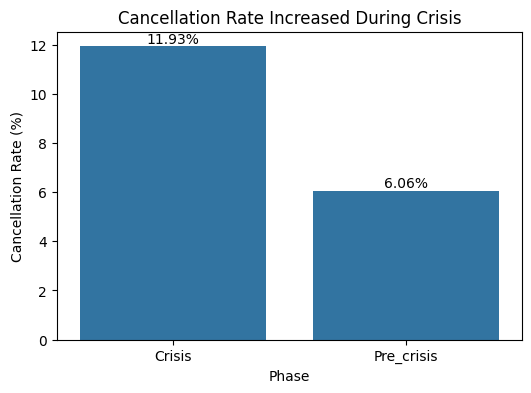

In [241]:
plt.figure(figsize=(6,4))
ax = sns.barplot(
    data=cancellation_phase,
    x='crisis_phase',
    y='cancellation_rate_%'
)

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}%",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title("Cancellation Rate Increased During Crisis")
plt.ylabel("Cancellation Rate (%)")
plt.xlabel("Phase")
plt.show()